<a href="https://colab.research.google.com/github/lukasbirki/BERT_SA_Corona_Warn_App/blob/main/Multilabel_ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment ML 2

Approach:
- Loading Data and preprocessing
- Model 1: Multilinual Model
- Model 2: Monolongual Model (German)

Compare Results

Source: 
- https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- https://github.com/JoMingyu/google-play-scraper
- https://www.philschmid.de/bert-text-classification-in-a-different-language

# A. Setting up Environment

### Connect to Google Drive, install necessary packages and connect to GPU

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install transformers
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import keras
print(keras.__version__)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import transformers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from transformers import BertTokenizer

     |████████████████████████████████| 2.2MB 15.2MB/s 
     |████████████████████████████████| 870kB 66.9MB/s 
     |████████████████████████████████| 3.3MB 54.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=d8e60ec5cb149e269e4091f59e2c69f1cf50db164e860ad234e2076ad3658cd2
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
2.4.3


In [4]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### Loading Data, shuffling and splitting them into train and test set

## Explorativ Data Analysis

In [5]:
df_Corona = pd.read_csv('/content/drive/MyDrive/Colab_Machine_Learning/50000_App.csv')
#Shuffling Data
df_Corona = shuffle(df_Corona)

#Creating new Variable with positive, neutral and negative
conditions_df = [
    (df_Corona["score"] == 5),
    (df_Corona["score"].gt(1) & df_Corona["score"].lt(5)),
    (df_Corona["score"] == 1),]
choices = [3, 2, 1]
df_Corona["adjusted"] = np.select(conditions_df, choices)

#Subsetting 
reviews = df_Corona.content
stars = df_Corona.score
stars_adjusted = df_Corona.adjusted
stars = stars -1
stars_adjusted = stars_adjusted -1

print(df_Corona.shape)



(50966, 12)


Univariate Distribution of Ratings

Text(0.5, 1.0, 'Histogramm of Ratings on all Reviews')

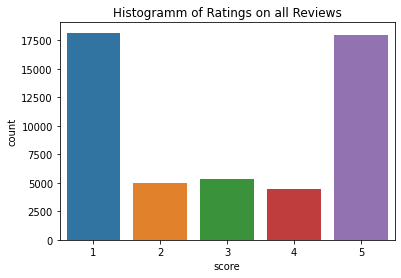

In [5]:
sns.countplot(x = 'score', data = df_Corona).set_title('Histogramm of Ratings on all Reviews')

Ratings over Time

In [6]:
df_Corona['at'] = pd.to_datetime(df_Corona['at'])
df_Corona['date'] = pd.to_datetime(df_Corona['at']).dt.date
df_Coronanew = df_Corona[['score','date']]
df_Coronanew = pd.DataFrame(df_Coronanew)
df_Coronanew = df_Coronanew.reset_index() 
x = df_Coronanew.groupby(['date','score']).count()
y = x.reset_index()
xyz = y.reset_index()
xyz['date'] = pd.to_datetime(xyz['date'])

alt.Chart(xyz).mark_line().encode(x=alt.X('date:T', title = 'Time', axis = alt.Axis(tickCount= 5)),
y= alt.Y('index:Q', title = 'Absolute Number of Reviews'),
color= alt.Color('score', title = 'Rating' ,type='nominal')
).properties(width=700, height = 400,title = 'Number of Reviews for the "Corona-Warn-App"').configure_view(
stroke='transparent'
)

alt.Chart(...)

In [7]:
#https://d3-wiki.readthedocs.io/zh_CN/master/Ordinal-Scales/ for the Colors

alt.Chart(xyz[xyz['date'] >= '2020-08-01']).mark_line().encode(x=alt.X('date:T', title = 'Time', axis = alt.Axis(tickCount= 5)),
y= alt.Y('index:Q', title = 'Absolute Number of Reviews'),
color= alt.Color('score', title = 'Rating' ,type='nominal', scale=alt.Scale(
            domain=['1', '2','3','4','5'],
            range=['red', '#fd8d3c','yellow','#8ca252','green']))
).properties(width=700, height = 400,title = 'Number of Reviews for the "Corona-Warn-App"').configure_view(
stroke='transparent'
)

alt.Chart(...)

In [ ]:
xyz

,level_0,date,score,index,Scores_new
0,0,2020-06-16,1,824,1 Star
1,1,2020-06-16,2,194,2 Stars
2,2,2020-06-16,3,266,3 Stars
3,3,2020-06-16,4,429,4 Stars
4,4,2020-06-16,5,5060,5 Stars
...,...,...,...,...,...
1308,1308,2021-03-05,1,29,1 Star
1309,1309,2021-03-05,2,8,2 Stars
1310,1310,2021-03-05,3,4,3 Stars
1311,1311,2021-03-05,4,2,4 Stars


In [9]:
xyz['Scores_new'] = xyz['score'].replace({1: '1 Star', 2: '2 Stars', 3: '3 Stars', 4: '4 Stars', 5:'5 Stars'})
alt.Chart(xyz).mark_bar().encode(
    x=alt.X('date',axis = alt.Axis(format='%Y-%B')),
    y=alt.Y('sum(index)', title='Total Number of Reviews per Day'),
    color= alt.Color('Scores_new', title = 'Rating' ,type='nominal',scale=alt.Scale(
            domain=['1 Star', '2 Stars','3 Stars','4 Stars','5 Stars'],
            range=['red', '#fd8d3c','yellow','#8ca252','green']))
).properties(width=700, height = 400,title = ['Daily Number of Reviews for the German "Corona-Warn-App" (Google Play Store)','Time Period: 2020-06-16 to 2021-03-05']).configure_view(
stroke='transparent'
)

alt.Chart(...)

In [10]:
alt.Chart(xyz[xyz['date'] >= '2020-06-20']).mark_bar().encode(
    x=alt.X('date',axis = alt.Axis(format='%Y-%B')),    
    y=alt.Y('sum(index)', title='Total Number of Reviews per Day'),
    color= alt.Color('Scores_new', title = 'Rating' ,type='nominal',scale=alt.Scale(
            domain=['1 Star', '2 Stars','3 Stars','4 Stars','5 Stars'],
            range=['red', '#fd8d3c','yellow','#8ca252','green']))
).properties(width=700, height = 400,title = ['Daily Number of Reviews for the German "Corona-Warn-App" (Google Play Store)','Time Period: 2020-06-20 to 2021-03-05 (restricted time period)']).configure_view(
stroke='transparent'
)

alt.Chart(...)

#E. Baseline Model: Naive Bayes Classifier

## 5 labels

In [56]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
sns.set() # use seaborn plotting style

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_Corona['content'], df_Corona['score'], random_state=1)
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)
top_words_df[0:100]

,0
app,33061
funktioniert,6602
seit,5448
mehr,5350
gut,4618
...,...
liegt,846
besser,845
gelöscht,843
20,843


In [58]:
from sklearn.naive_bayes import MultinomialNB

  t0 = time.time()

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Balanced score: ', balanced_accuracy_score(y_test, predictions))

Accuracy score:  0.6303563019934076
Balanced score:  0.3976337405070521


Text(80.90000000000006, 0.5, 'predicted label')

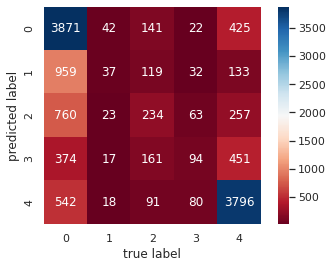

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=True, fmt='d')
plt.xlabel('true label')
plt.ylabel('predicted label')

In [43]:
testing_predictions = []
for i in range(len(X_test)):
    if predictions[i] == 1:
        testing_predictions.append('1 Star')
    elif predictions[i] == 2:
        testing_predictions.append('2 Stars')
    elif predictions[i] == 3:
        testing_predictions.append('3 Stars')
    elif predictions[i] == 4:
        testing_predictions.append('4 Stars')
    else:
        testing_predictions.append('5 Stars')

check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions, 'Review Text':list(X_test)})

,actual_label,prediction,abstract
0,1,1 Star,"Die App ist völlig nutzlos, mein Testergebnis ..."
1,5,5 Stars,Diese App ist sehr gut.
2,5,5 Stars,Gute Sache
3,3,1 Star,Empfehlenswert. Ich wünsche mir aber eine Meld...
4,1,1 Star,Einfach nur armselig! Eine App die einen vor C...
...,...,...,...
12737,1,1 Star,Die App hat über zwei Wochen stabil funktionie...
12738,1,1 Star,Mit einer ausländischen Nummer kann man leider...
12739,1,1 Star,Der fehler besteht schon sehr lange und ich ha...
12740,1,1 Star,Nach der Installation der App hat der Akku nur...


## 3 labels

In [44]:
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

sns.set() # use seaborn plotting style

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_Corona['content'], df_Corona['adjusted'], random_state=1)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

german_stop_words = stopwords.words('german')

cv = CountVectorizer(stop_words = german_stop_words) # Now use this in your pipeline

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)
top_words_df[0:100]

,0
app,33061
funktioniert,6602
seit,5448
mehr,5350
gut,4618
...,...
liegt,846
besser,845
gelöscht,843
20,843


In [49]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Balanced score: ', balanced_accuracy_score(y_test, predictions))

Accuracy score:  0.6946319259142991
Accuracy score:  0.6856773276384708


Text(80.90000000000006, 0.5, 'predicted label')

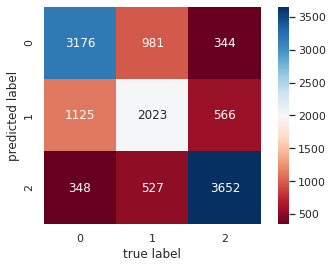

In [52]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=True, fmt='d')
plt.xlabel('true label')
plt.ylabel('predicted label')

# B. Data Preprocessing BERT

In [7]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#Loading Multilingual Tokenizer
tokenizer_mono = BertTokenizer.from_pretrained('bert-base-german-cased', do_lower_case=True, strip_accents = False)

input_ids_mono = []
attention_masks_mono = []

# For every sentence...
for sent in reviews:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict_mono = tokenizer_mono.__call__(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_tensors = 'pt', 
                        return_attention_mask=True,
                        truncation=True    # Return pytorch tensors.
                   )

    input_ids_mono.append(encoded_dict_mono['input_ids'])
    attention_masks_mono.append(encoded_dict_mono['attention_mask'])

# Convert the lists into tensors and combining them into one single Tensordataset
input_ids_mono = torch.cat(input_ids_mono, dim=0)
attention_masks_mono = torch.cat(attention_masks_mono, dim=0)
labels = torch.tensor(stars.values)
dataset_mono = TensorDataset(input_ids_mono, attention_masks_mono, labels)

# Splitting dataset into test_dataset and train_dataset
train_size = int(0.8 * len(dataset_mono))
test_size = len(dataset_mono) - train_size
train_dataset_mono, test_dataset_mono = random_split(dataset_mono, [train_size, test_size])

# Splitting test into test and train Set
train_size = int(0.9 * len(train_dataset_mono))
val_size = len(train_dataset_mono) - train_size
train_dataset_mono, val_dataset_mono = random_split(train_dataset_mono, [train_size, val_size])

print('{:>5,} test samples'.format(test_size))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

#Sending Test, Validation and Train Tensordatasets to Dataloader
batch_size = 16
train_dataloader_mono = DataLoader(
            train_dataset_mono,  
            sampler = RandomSampler(train_dataset_mono), 
            batch_size = batch_size 
        )
validation_dataloader_mono = DataLoader(
            val_dataset_mono, 
            sampler = SequentialSampler(val_dataset_mono),
            batch_size = batch_size 
        )
test_dataloader_mono = DataLoader(
            test_dataset_mono,
            sampler = SequentialSampler(test_dataset_mono), 
            batch_size = batch_size
)

print('')
print('Done')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


10,194 test samples
36,694 training samples
4,078 validation samples

Done


In [ ]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#Loading Multilingual Tokenizer
tokenizer_multi = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True, strip_accents = False)

input_ids_multi = []
attention_masks_multi = []

# For every sentence...
for sent in reviews:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict_multi = tokenizer_multi.__call__(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_tensors = 'pt', 
                        return_attention_mask=True,
                        truncation=True    # Return pytorch tensors.
                   )

    input_ids_multi.append(encoded_dict_multi['input_ids'])
    attention_masks_multi.append(encoded_dict_multi['attention_mask'])

# Convert the lists into tensors and combining them into one single Tensordataset
input_ids_multi = torch.cat(input_ids_multi, dim=0)
attention_masks_multi = torch.cat(attention_masks_multi, dim=0)
labels = torch.tensor(stars.values)
dataset_multi = TensorDataset(input_ids_multi, attention_masks_multi, labels)

# Splitting dataset into test_dataset and train_dataset
train_size = int(0.8 * len(dataset_multi))
test_size = len(dataset_multi) - train_size
train_dataset_multi, test_dataset_multi = random_split(dataset_multi, [train_size, test_size])

# Splitting test into test and train Set
train_size = int(0.9 * len(train_dataset_multi))
val_size = len(train_dataset_multi) - train_size
train_dataset_multi, val_dataset_multi = random_split(train_dataset_multi, [train_size, val_size])

print('{:>5,} test samples'.format(test_size))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

#Sending Test, Validation and Train Tensordatasets to Dataloader
batch_size = 16
train_dataloader_multi = DataLoader(
            train_dataset_multi,  
            sampler = RandomSampler(train_dataset_multi), 
            batch_size = batch_size 
        )
validation_dataloader_multi = DataLoader(
            val_dataset_multi, 
            sampler = SequentialSampler(val_dataset_multi),
            batch_size = batch_size 
        )
test_dataloader_multi = DataLoader(
            test_dataset_multi,
            sampler = SequentialSampler(test_dataset_multi), 
            batch_size = batch_size
)

print('')
print('Done')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


10,194 test samples
36,694 training samples
4,078 validation samples

Done


## Checking Token Lenght

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


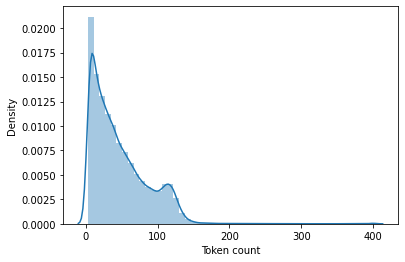

In [16]:
import matplotlib.pyplot as plt

token_lens = []
for txt in df_Corona.content:
  tokens = tokenizer_mono.encode(txt, max_length=400)
  token_lens.append(len(tokens))

picture = sns.distplot(token_lens)
plt.xlabel('Token count');

In [14]:
import collections
counter=collections.Counter(token_lens)
print(counter)

Counter({4: 1265, 5: 1250, 6: 1210, 7: 1126, 8: 990, 9: 952, 10: 909, 3: 866, 11: 836, 13: 824, 12: 820, 15: 787, 14: 780, 16: 776, 19: 711, 18: 698, 17: 688, 22: 672, 21: 667, 25: 660, 26: 654, 20: 653, 23: 652, 29: 626, 24: 617, 31: 604, 28: 585, 30: 572, 33: 566, 27: 566, 37: 564, 38: 539, 35: 536, 41: 523, 34: 522, 36: 511, 32: 502, 39: 498, 40: 483, 43: 462, 45: 460, 42: 453, 46: 428, 53: 415, 49: 407, 44: 402, 52: 395, 47: 395, 51: 391, 50: 385, 48: 384, 55: 367, 57: 358, 58: 356, 56: 348, 54: 344, 61: 340, 59: 335, 67: 319, 62: 316, 63: 314, 60: 313, 65: 303, 64: 300, 68: 294, 66: 289, 71: 273, 70: 256, 69: 254, 75: 254, 77: 246, 73: 244, 78: 234, 76: 234, 117: 234, 121: 228, 72: 222, 115: 220, 113: 219, 112: 217, 116: 215, 82: 215, 114: 214, 74: 210, 110: 205, 79: 205, 119: 202, 83: 202, 109: 201, 86: 201, 106: 200, 111: 199, 84: 199, 81: 196, 90: 196, 108: 195, 80: 195, 87: 192, 118: 192, 92: 190, 94: 189, 123: 189, 91: 188, 120: 186, 104: 184, 89: 184, 88: 182, 107: 181, 85: 

# C. Model 1: Monolingual

### Define Monolingual Model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model_mono = BertForSequenceClassification.from_pretrained(
    "bert-base-german-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

print('')

model_mono.cuda()


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader_mono) * epochs

optimizer = AdamW(model_mono.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)



##Training

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times as hh:mm:ss

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats_mono = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model_mono.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader_mono):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader_mono), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model_mono.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model_mono(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model_mono.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader_mono)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model_mono.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader_mono:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model_mono(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader_mono)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader_mono)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats_mono.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  2,294.    Elapsed: 0:00:20.
  Batch    80  of  2,294.    Elapsed: 0:00:40.
  Batch   120  of  2,294.    Elapsed: 0:01:00.
  Batch   160  of  2,294.    Elapsed: 0:01:21.
  Batch   200  of  2,294.    Elapsed: 0:01:41.
  Batch   240  of  2,294.    Elapsed: 0:02:01.
  Batch   280  of  2,294.    Elapsed: 0:02:21.
  Batch   320  of  2,294.    Elapsed: 0:02:41.
  Batch   360  of  2,294.    Elapsed: 0:03:01.
  Batch   400  of  2,294.    Elapsed: 0:03:21.
  Batch   440  of  2,294.    Elapsed: 0:03:41.
  Batch   480  of  2,294.    Elapsed: 0:04:01.
  Batch   520  of  2,294.    Elapsed: 0:04:21.
  Batch   560  of  2,294.    Elapsed: 0:04:41.
  Batch   600  of  2,294.    Elapsed: 0:05:01.
  Batch   640  of  2,294.    Elapsed: 0:05:21.
  Batch   680  of  2,294.    Elapsed: 0:05:41.
  Batch   720  of  2,294.    Elapsed: 0:06:02.
  Batch   760  of  2,294.    Elapsed: 0:06:22.
  Batch   800  of  2,294.    Elapsed: 0:06:42.
  Batch   840  of

## Visualizing and Analysing Results

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats_mono = pd.DataFrame(data=training_stats_mono)

# Use the 'epoch' as the row index.
df_stats_mono = df_stats_mono.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats_mono

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.91,0.81,0.69,0:19:12,0:00:38
2,0.72,0.82,0.69,0:19:18,0:00:39


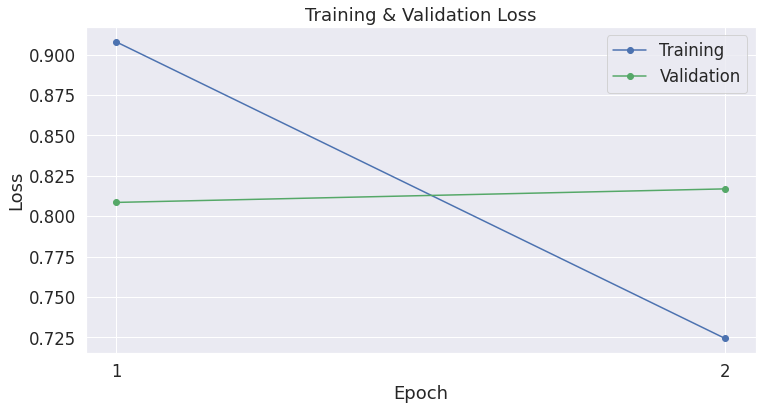

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats_mono['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats_mono['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])

plt.show()

## Testing

In [ ]:
test_dataset_mono
prediction_sampler_mono = SequentialSampler(test_dataset_mono)
prediction_dataloader_mono = DataLoader(test_dataset_mono, sampler=prediction_sampler_mono, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset_mono)))

# Put model in evaluation mode
model_mono.eval()

# Tracking variables 
predictions_mono , true_labels_mono = [], []

# Predict 
for batch in test_dataloader_mono:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model_mono(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_mono.append(logits)
  true_labels_mono.append(label_ids)

print('    DONE.')

Predicting labels for 10,194 test sentences...
    DONE.


In [ ]:
print(true_labels_mono[0])
print(predictions_mono[0])

[0 4 2 4 4 0 4 3 1 3 3 0 4 1 0 0]
[[ 4.589082    0.75394714 -1.3093244  -2.542929   -2.0926423 ]
 [-2.0657063  -2.295465   -1.2962898   1.324208    5.005747  ]
 [-2.2580905  -1.1252809   1.1244539   1.7449403   0.5870063 ]
 [-1.8664746  -2.3870509  -1.1067454   1.6400917   5.590362  ]
 [-1.5158584  -2.4167655  -1.3080684   1.4206082   5.2224417 ]
 [ 0.11149705 -1.398812   -0.4551178   0.23599663  0.96156496]
 [-2.2421174  -2.343614   -0.9670802   1.7508303   5.406732  ]
 [-1.8739299  -1.7719563  -0.22684139  1.7413712   2.2580438 ]
 [ 0.9778629   0.7779645   0.34595692 -1.2309864  -1.1917466 ]
 [ 0.41991377 -0.67942727 -0.18491335 -0.11120989  0.10514011]
 [-1.8470767  -0.95044965  1.127133    1.5476288   0.1707204 ]
 [-0.5807849   0.55094635  1.4314581   0.14411959 -1.5270978 ]
 [-2.497148   -0.8645059   0.8291114   2.1856022   0.8814925 ]
 [ 0.8539855   0.25196928  0.14745821 -0.40032965 -1.4642509 ]
 [ 3.1565897   1.6185471   0.03378526 -2.2092361  -3.0471542 ]
 [ 4.6159716   0.3417

In [ ]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
import numpy as np

balanced_acc_set_mono = []
global_prediction_mono = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Estimating Balanced_accuracy_score for each batch...')

# For each input batch...
for i in range(len(true_labels_mono)):
  
  # The predictions for this batch are a 5-column ndarray (from "0" (1 Star) 
  # to "4" (5 Stars)). Pick the label with the highest value and turn this
  # in to a list.
  pred_labels_i = np.argmax(predictions_mono[i], axis=1).flatten()
  global_prediction_mono.append(pred_labels_i)
  
  # Calculate and store the coef for this batch.  
  balanced_acc = balanced_accuracy_score(true_labels_mono[i], pred_labels_i)                
  balanced_acc_set_mono.append(balanced_acc)

Estimating Balanced_accuracy_score for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [ ]:
flat_list = [item for sublist in global_prediction_mono for item in sublist]

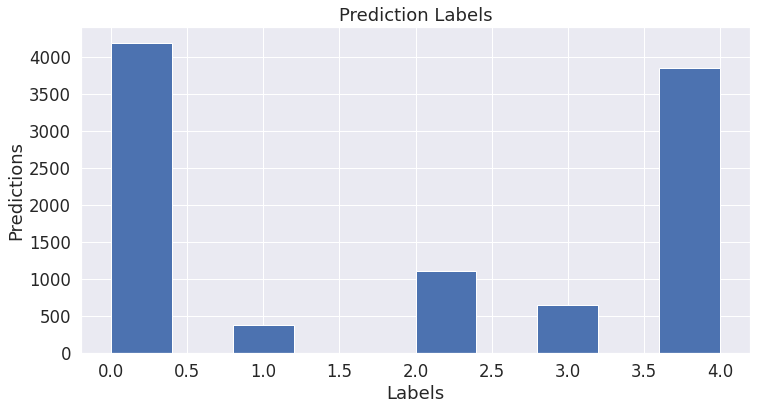

In [ ]:
# Distribution of Predictions
plt.hist(flat_list)
plt.title('Prediction Labels')
plt.ylabel('Predictions')
plt.xlabel('Labels')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions_mono, axis=0)

# For each sample, pick the label (0 to 4) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels_mono = np.concatenate(true_labels_mono, axis=0)

# Calculate the MCC
acc = balanced_accuracy_score(flat_true_labels_mono, flat_predictions)
acc_absolut = accuracy_score(flat_true_labels_mono, flat_predictions)

print('Total balanced_acc_set: %.3f' % acc)
print('Total acc_set: %.3f' % acc_absolut)

Total balanced_acc_set: 0.490
Total acc_set: 0.682


Accuracy score:  0.6823621738277418


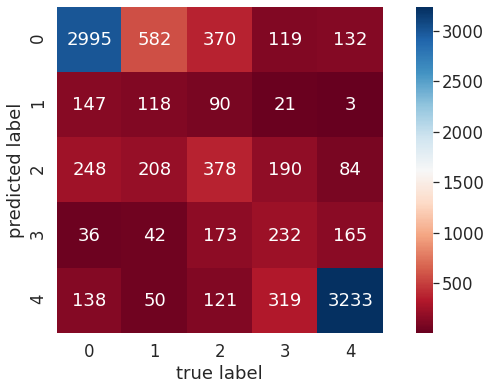

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(flat_predictions, flat_true_labels_mono)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=True, fmt='d')
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy score: ', accuracy_score(flat_predictions, flat_true_labels_mono))

In [ ]:
columns = ["1", "2", "3","4","5"]
rows = ["1", "2", "3","4","5"]
cm_mono_5 = pd.DataFrame(data=cm, index=rows, columns=columns)
print(cm_mono_5)
cm_mono_5.to_csv('confusion_matrix_mono_5.csv')
!cp confusion_matrix_mono_5.csv "drive/My Drive/Colab_Machine_Learning/Gespeicherte Modelle/Confusion_Matrices/"

      1    2    3    4     5
1  2995  582  370  119   132
2   147  118   90   21     3
3   248  208  378  190    84
4    36   42  173  232   165
5   138   50  121  319  3233


## Saving Model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_monolingual_5/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model_mono.module if hasattr(model_mono, 'module') else model_mono  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_mono.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

!cp -r ./model_save_monolingual_5/ "drive/MyDrive/Colab_Machine_Learning/Gespeicherte Modelle/monolingual_5"

Saving model to ./model_save_monolingual_5/


('./model_save_monolingual_5/tokenizer_config.json',
 './model_save_monolingual_5/special_tokens_map.json',
 './model_save_monolingual_5/vocab.txt',
 './model_save_monolingual_5/added_tokens.json')

#D. Model 2: Multilingual

### Define Multilingual Model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model_multi = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

print('')

model_multi.cuda()


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader_multi) * epochs

optimizer = AdamW(model_multi.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)



##Training

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats_multi = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model_multi.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader_multi):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader_multi), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model_multi.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model_multi(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model_multi.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader_multi)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model_multi.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader_multi:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model_multi(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader_multi)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader_multi)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats_multi.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  2,294.    Elapsed: 0:00:21.
  Batch    80  of  2,294.    Elapsed: 0:00:41.
  Batch   120  of  2,294.    Elapsed: 0:01:02.
  Batch   160  of  2,294.    Elapsed: 0:01:22.
  Batch   200  of  2,294.    Elapsed: 0:01:43.
  Batch   240  of  2,294.    Elapsed: 0:02:04.
  Batch   280  of  2,294.    Elapsed: 0:02:24.
  Batch   320  of  2,294.    Elapsed: 0:02:45.
  Batch   360  of  2,294.    Elapsed: 0:03:05.
  Batch   400  of  2,294.    Elapsed: 0:03:26.
  Batch   440  of  2,294.    Elapsed: 0:03:47.
  Batch   480  of  2,294.    Elapsed: 0:04:07.
  Batch   520  of  2,294.    Elapsed: 0:04:28.
  Batch   560  of  2,294.    Elapsed: 0:04:48.
  Batch   600  of  2,294.    Elapsed: 0:05:09.
  Batch   640  of  2,294.    Elapsed: 0:05:30.
  Batch   680  of  2,294.    Elapsed: 0:05:50.
  Batch   720  of  2,294.    Elapsed: 0:06:11.
  Batch   760  of  2,294.    Elapsed: 0:06:31.
  Batch   800  of  2,294.    Elapsed: 0:06:52.
  Batch   840  of

## Visualizing and Analysing Results

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats_multi = pd.DataFrame(data=training_stats_multi)

# Use the 'epoch' as the row index.
df_stats_multi = df_stats_multi.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats_multi

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.96,0.87,0.66,0:19:40,0:00:38
2,0.78,0.84,0.68,0:19:44,0:00:38


## Testing

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset_multi)))

# Put model in evaluation mode
model_multi.eval()

# Tracking variables 
predictions_multi , true_labels_multi = [], []

# Predict 
for batch in test_dataloader_multi:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model_multi(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_multi.append(logits)
  true_labels_multi.append(label_ids)

print('    DONE.')

[array([[ 1.5962061 ,  1.1776042 , -2.1977391 ],
        [-1.3738276 ,  2.0249047 , -0.49196902],
        [ 2.6908658 ,  0.7584609 , -2.8881607 ],
        [ 1.6099753 ,  0.70946586, -1.8623308 ],
        [-2.8347118 ,  0.12742333,  2.3970096 ],
        [-3.319519  , -0.5563503 ,  3.4217794 ],
        [ 2.7652729 , -0.10454625, -2.0615354 ],
        [ 0.8713106 ,  1.9502742 , -2.4099846 ],
        [-3.1864684 , -0.51869655,  3.288676  ],
        [-1.4803996 ,  1.8790824 , -0.38484487],
        [-3.4322028 ,  0.31176353,  2.8611197 ],
        [-2.7443001 , -0.63006604,  3.073776  ],
        [-3.2717874 , -0.59914625,  3.3545797 ],
        [-2.6313243 ,  0.5955628 ,  1.8473921 ],
        [ 1.1060009 ,  1.056819  , -1.6546866 ],
        [-3.2943494 , -0.59885514,  3.4085436 ]], dtype=float32),
 array([[-3.3587735 , -0.26998326,  3.1757617 ],
        [-2.96843   , -0.31972566,  2.9319763 ],
        [ 1.7135004 ,  0.9821633 , -2.110468  ],
        [-3.3372645 , -0.00584412,  2.9329293 ],
   

In [ ]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
import numpy as np

balanced_acc_set = []
global_prediction_multi = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Estimating Balanced_accuracy_score for each batch...')

# For each input batch...
for i in range(len(true_labels_multi)):
  
  # The predictions for this batch are a 5-column ndarray (from "0" (1 Star) 
  # to "4" (5 Stars)). Pick the label with the highest value and turn this
  # in to a list.
  pred_labels_i = np.argmax(predictions_multi[i], axis=1).flatten()
  global_prediction_multi.append(pred_labels_i)
  
  # Calculate and store the coef for this batch.  
  balanced_acc = balanced_accuracy_score(true_labels_multi[i], pred_labels_i)                
  balanced_acc_set.append(balanced_acc)

In [ ]:
flat_list_multi = [item for sublist in global_prediction_multi for item in sublist]

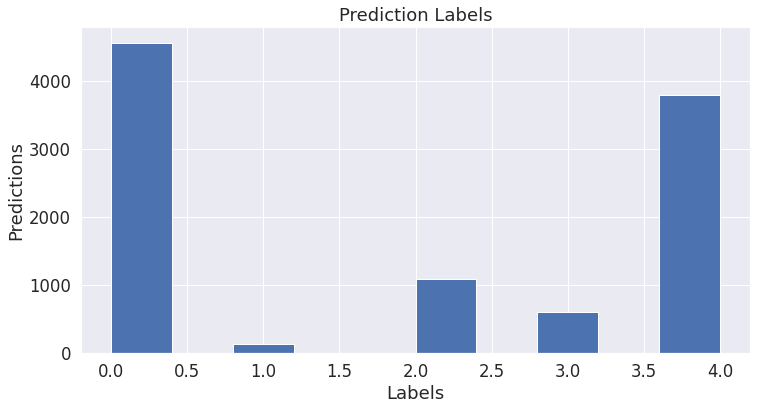

In [ ]:
# Distribution of Predictions
plt.hist(flat_list_multi)
plt.title('Prediction Labels')
plt.ylabel('Predictions')
plt.xlabel('Labels')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions_multi, axis=0)

# For each sample, pick the label (0 to 4) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels_multi = np.concatenate(true_labels_multi, axis=0)

# Calculate the MCC
acc = balanced_accuracy_score(flat_true_labels_multi, flat_predictions)

print('Total balanced_acc_set: %.3f' % acc)

Total balanced_acc_set: 0.475


Accuracy score:  0.6788306847164999


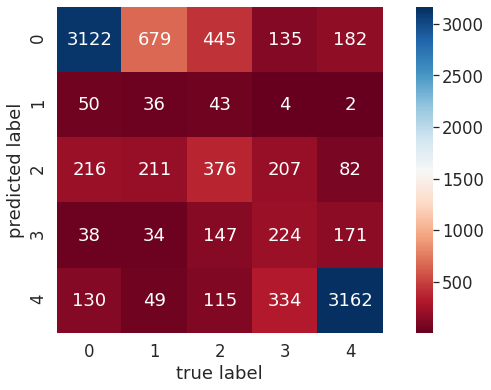

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(flat_predictions, flat_true_labels_multi)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=True, fmt='d')
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy score: ', accuracy_score(flat_predictions, flat_true_labels_multi))

In [ ]:
columns = ["1", "2", "3","4","5"]
rows = ["1", "2", "3","4","5"]
cm_multi_5 = pd.DataFrame(data=cm, index=rows, columns=columns)
print(cm_multi_5)
cm_multi_5.to_csv('confusion_matrix_multi_5.csv')
!cp confusion_matrix_multi_5.csv "drive/My Drive/Colab_Machine_Learning/Gespeicherte Modelle/Confusion_Matrices/"

      1    2    3    4     5
1  3122  679  445  135   182
2    50   36   43    4     2
3   216  211  376  207    82
4    38   34  147  224   171
5   130   49  115  334  3162


## Saving Model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_multilingual_5/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model_mono.module if hasattr(model_mono, 'module') else model_mono  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_mono.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

!cp -r ./model_save_multilingual_5/ "drive/MyDrive/Colab_Machine_Learning/Gespeicherte Modelle/multilingual_5"

Saving model to ./model_save_multilingual_5/


# C2. Model 1: Monolingual

In [ ]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#Loading Multilingual Tokenizer
tokenizer_mono = BertTokenizer.from_pretrained('bert-base-german-cased', do_lower_case=True, strip_accents = False)

input_ids_mono = []
attention_masks_mono = []

# For every sentence...
for sent in reviews:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict_mono = tokenizer_mono.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_tensors = 'pt', 
                        return_attention_mask=True,
                        truncation=True    # Return pytorch tensors.
                   )

    input_ids_mono.append(encoded_dict_mono['input_ids'])
    attention_masks_mono.append(encoded_dict_mono['attention_mask'])

# Convert the lists into tensors and combining them into one single Tensordataset
input_ids_mono = torch.cat(input_ids_mono, dim=0)
attention_masks_mono = torch.cat(attention_masks_mono, dim=0)
labels = torch.tensor(stars_adjusted.values)
dataset_mono = TensorDataset(input_ids_mono, attention_masks_mono, labels)

# Splitting dataset into test_dataset and train_dataset
train_size = int(0.8 * len(dataset_mono))
test_size = len(dataset_mono) - train_size
train_dataset_mono, test_dataset_mono = random_split(dataset_mono, [train_size, test_size])

# Splitting test into test and train Set
train_size = int(0.9 * len(train_dataset_mono))
val_size = len(train_dataset_mono) - train_size
train_dataset_mono, val_dataset_mono = random_split(train_dataset_mono, [train_size, val_size])

print('{:>5,} test samples'.format(test_size))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

#Sending Test, Validation and Train Tensordatasets to Dataloader
batch_size = 16
train_dataloader_mono = DataLoader(
            train_dataset_mono,  
            sampler = RandomSampler(train_dataset_mono), 
            batch_size = batch_size 
        )
validation_dataloader_mono = DataLoader(
            val_dataset_mono, 
            sampler = SequentialSampler(val_dataset_mono),
            batch_size = batch_size 
        )
test_dataloader_mono = DataLoader(
            test_dataset_mono,
            sampler = SequentialSampler(test_dataset_mono), 
            batch_size = batch_size
)

print('')
print('Done')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


10,194 test samples
36,694 training samples
4,078 validation samples

Done


### Define Monolingual Model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model_mono = BertForSequenceClassification.from_pretrained(
    "bert-base-german-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

print('')

model_mono.cuda()


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader_mono) * epochs

optimizer = AdamW(model_mono.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)



##Training

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times as hh:mm:ss

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats_mono = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model_mono.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader_mono):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader_mono), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model_mono.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model_mono(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model_mono.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader_mono)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model_mono.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader_mono:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model_mono(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader_mono)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader_mono)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats_mono.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  2,294.    Elapsed: 0:00:20.
  Batch    80  of  2,294.    Elapsed: 0:00:40.
  Batch   120  of  2,294.    Elapsed: 0:01:00.
  Batch   160  of  2,294.    Elapsed: 0:01:21.
  Batch   200  of  2,294.    Elapsed: 0:01:41.
  Batch   240  of  2,294.    Elapsed: 0:02:01.
  Batch   280  of  2,294.    Elapsed: 0:02:21.
  Batch   320  of  2,294.    Elapsed: 0:02:41.
  Batch   360  of  2,294.    Elapsed: 0:03:01.
  Batch   400  of  2,294.    Elapsed: 0:03:21.
  Batch   440  of  2,294.    Elapsed: 0:03:41.
  Batch   480  of  2,294.    Elapsed: 0:04:01.
  Batch   520  of  2,294.    Elapsed: 0:04:21.
  Batch   560  of  2,294.    Elapsed: 0:04:42.
  Batch   600  of  2,294.    Elapsed: 0:05:02.
  Batch   640  of  2,294.    Elapsed: 0:05:22.
  Batch   680  of  2,294.    Elapsed: 0:05:42.
  Batch   720  of  2,294.    Elapsed: 0:06:02.
  Batch   760  of  2,294.    Elapsed: 0:06:22.
  Batch   800  of  2,294.    Elapsed: 0:06:42.
  Batch   840  of

## Visualizing and Analysing Results

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats_mono = pd.DataFrame(data=training_stats_mono)

# Use the 'epoch' as the row index.
df_stats_mono = df_stats_mono.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats_mono

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.64,0.57,0.75,0:19:11,0:00:38
2,0.47,0.58,0.76,0:19:12,0:00:38


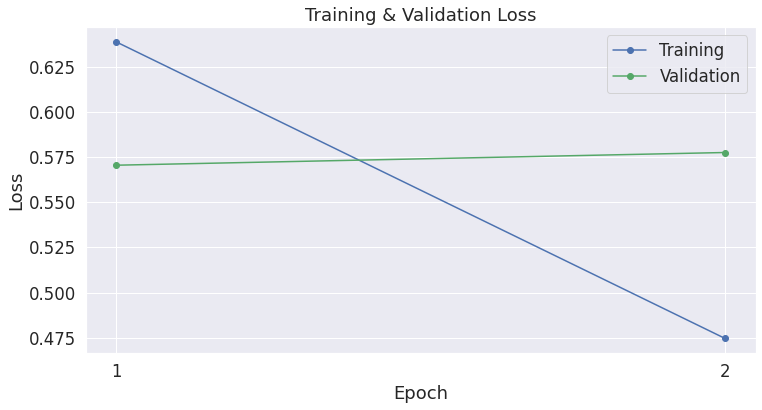

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats_mono['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats_mono['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])

plt.show()

## Testing

In [ ]:
test_dataset_mono
prediction_sampler_mono = SequentialSampler(test_dataset_mono)
prediction_dataloader_mono = DataLoader(test_dataset_mono, sampler=prediction_sampler_mono, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset_mono)))

# Put model in evaluation mode
model_mono.eval()

# Tracking variables 
predictions_mono , true_labels_mono = [], []

# Predict 
for batch in test_dataloader_mono:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model_mono(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_mono.append(logits)
  true_labels_mono.append(label_ids)

print('    DONE.')

Predicting labels for 10,194 test sentences...
    DONE.


In [ ]:
print(true_labels_mono[0])
print(predictions_mono[0])

[0 2 2 2 2 1 2 1 0 0 2 0 1 0 0 2]
[[ 0.5295091   0.9551276  -1.7829438 ]
 [-1.1450198   1.8538522  -0.74000794]
 [-3.1299593  -0.98649496  4.0418653 ]
 [-4.0419545  -0.3186942   3.8304107 ]
 [-4.030346   -0.35810584  3.7749465 ]
 [-1.0718678   1.4327687  -0.6821063 ]
 [-2.9186246  -1.3718303   3.827007  ]
 [-0.5903717   2.1752634  -1.7820636 ]
 [ 3.445234   -0.11945145 -3.5117455 ]
 [ 0.47997072  0.48470914 -1.4239533 ]
 [-3.5361285  -0.19063066  3.4771693 ]
 [-0.264274    1.0995404  -1.4807884 ]
 [-0.89826596  2.1827078  -1.0069427 ]
 [ 1.6787602   0.57562387 -2.4792857 ]
 [-1.7667701   1.8071076  -0.23981124]
 [-3.539416   -0.34019503  3.7209287 ]]


In [ ]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
import numpy as np

balanced_acc_set_mono = []
global_prediction_mono = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Estimating Balanced_accuracy_score for each batch...')

# For each input batch...
for i in range(len(true_labels_mono)):
  
  # The predictions for this batch are a 5-column ndarray (from "0" (1 Star) 
  # to "4" (5 Stars)). Pick the label with the highest value and turn this
  # in to a list.
  pred_labels_i = np.argmax(predictions_mono[i], axis=1).flatten()
  global_prediction_mono.append(pred_labels_i)
  
  # Calculate and store the coef for this batch.  
  balanced_acc = balanced_accuracy_score(true_labels_mono[i], pred_labels_i)                
  balanced_acc_set_mono.append(balanced_acc)

Estimating Balanced_accuracy_score for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [ ]:
flat_list = [item for sublist in global_prediction_mono for item in sublist]

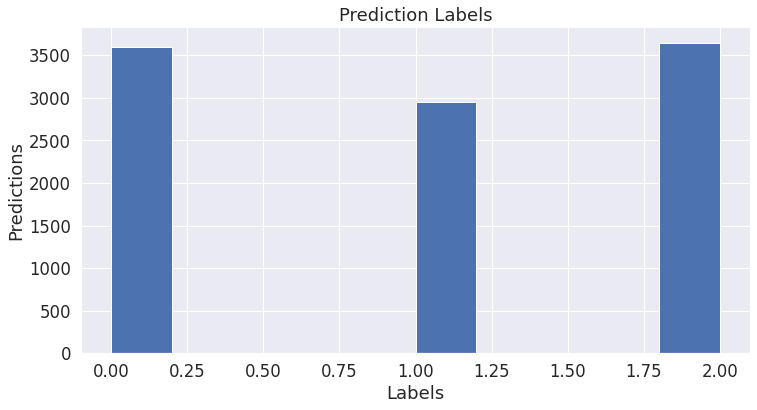

In [ ]:
# Distribution of Predictions
plt.hist(flat_list)
plt.title('Prediction Labels')
plt.ylabel('Predictions')
plt.xlabel('Labels')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions_mono, axis=0)

# For each sample, pick the label (0 to 4) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels_mono = np.concatenate(true_labels_mono, axis=0)

# Calculate the MCC
acc = balanced_accuracy_score(flat_true_labels_mono, flat_predictions)

print('Total balanced_acc_set: %.3f' % acc)

Total balanced_acc_set: 0.751


Accuracy score:  0.757504414361389


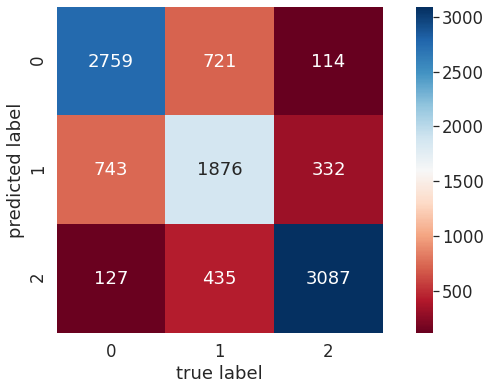

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(flat_predictions, flat_true_labels_mono)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=True, fmt='d')
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy score: ', accuracy_score(flat_predictions, flat_true_labels_mono))

In [ ]:
columns = ["1", "2", "3"]
rows = ["1", "2", "3"]
cm_mono_3 = pd.DataFrame(data=cm, index=rows, columns=columns)
print(cm_mono_3)
cm_mono_3.to_csv('confusion_matrix_mono_3.csv')
!cp confusion_matrix_mono_3.csv "drive/My Drive/Colab_Machine_Learning/Gespeicherte Modelle/Confusion_Matrices/"

      1     2     3
1  2759   721   114
2   743  1876   332
3   127   435  3087


## Saving Model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_monolingual_3/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model_mono.module if hasattr(model_mono, 'module') else model_mono  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_mono.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

!cp -r ./model_save_monolingual_3/ "drive/MyDrive/Colab_Machine_Learning/Gespeicherte Modelle/monolingual_3"

Saving model to ./model_save_monolingual_3/


#D2. Model 2: Multilingual

In [ ]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#Loading Multilingual Tokenizer
tokenizer_multi = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True, strip_accents = False)

input_ids_multi = []
attention_masks_multi = []

# For every sentence...
for sent in reviews:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict_multi = tokenizer_multi.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_tensors = 'pt', 
                        return_attention_mask=True,
                        truncation=True    # Return pytorch tensors.
                   )

    input_ids_multi.append(encoded_dict_multi['input_ids'])
    attention_masks_multi.append(encoded_dict_multi['attention_mask'])

# Convert the lists into tensors and combining them into one single Tensordataset
input_ids_multi = torch.cat(input_ids_multi, dim=0)
attention_masks_multi = torch.cat(attention_masks_multi, dim=0)
labels = torch.tensor(stars_adjusted.values)
dataset_multi = TensorDataset(input_ids_multi, attention_masks_multi, labels)

# Splitting dataset into test_dataset and train_dataset
train_size = int(0.8 * len(dataset_multi))
test_size = len(dataset_multi) - train_size
train_dataset_multi, test_dataset_multi = random_split(dataset_multi, [train_size, test_size])

# Splitting test into test and train Set
train_size = int(0.9 * len(train_dataset_multi))
val_size = len(train_dataset_multi) - train_size
train_dataset_multi, val_dataset_multi = random_split(train_dataset_multi, [train_size, val_size])

print('{:>5,} test samples'.format(test_size))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

#Sending Test, Validation and Train Tensordatasets to Dataloader
batch_size = 16
train_dataloader_multi = DataLoader(
            train_dataset_multi,  
            sampler = RandomSampler(train_dataset_multi), 
            batch_size = batch_size 
        )
validation_dataloader_multi = DataLoader(
            val_dataset_multi, 
            sampler = SequentialSampler(val_dataset_multi),
            batch_size = batch_size 
        )
test_dataloader_multi = DataLoader(
            test_dataset_multi,
            sampler = SequentialSampler(test_dataset_multi), 
            batch_size = batch_size
)

print('')
print('Done')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


10,194 test samples
36,694 training samples
4,078 validation samples

Done


### Define Multilingual Model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model_multi = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

print('')

model_multi.cuda()


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader_multi) * epochs

optimizer = AdamW(model_multi.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)



##Training

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats_multi = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model_multi.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader_multi):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader_multi), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model_multi.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model_multi(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model_multi.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader_multi)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model_multi.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader_multi:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model_multi(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader_multi)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader_multi)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats_multi.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  2,294.    Elapsed: 0:00:21.
  Batch    80  of  2,294.    Elapsed: 0:00:41.
  Batch   120  of  2,294.    Elapsed: 0:01:02.
  Batch   160  of  2,294.    Elapsed: 0:01:23.
  Batch   200  of  2,294.    Elapsed: 0:01:43.
  Batch   240  of  2,294.    Elapsed: 0:02:04.
  Batch   280  of  2,294.    Elapsed: 0:02:24.
  Batch   320  of  2,294.    Elapsed: 0:02:45.
  Batch   360  of  2,294.    Elapsed: 0:03:06.
  Batch   400  of  2,294.    Elapsed: 0:03:26.
  Batch   440  of  2,294.    Elapsed: 0:03:47.
  Batch   480  of  2,294.    Elapsed: 0:04:07.
  Batch   520  of  2,294.    Elapsed: 0:04:28.
  Batch   560  of  2,294.    Elapsed: 0:04:49.
  Batch   600  of  2,294.    Elapsed: 0:05:09.
  Batch   640  of  2,294.    Elapsed: 0:05:30.
  Batch   680  of  2,294.    Elapsed: 0:05:51.
  Batch   720  of  2,294.    Elapsed: 0:06:11.
  Batch   760  of  2,294.    Elapsed: 0:06:32.
  Batch   800  of  2,294.    Elapsed: 0:06:52.
  Batch   840  of

## Visualizing and Analysing Results

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats_multi = pd.DataFrame(data=training_stats_multi)

# Use the 'epoch' as the row index.
df_stats_multi = df_stats_multi.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats_multi

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.68,0.59,0.75,0:19:41,0:00:38
2,0.52,0.58,0.76,0:19:41,0:00:38


## Testing

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset_multi)))

# Put model in evaluation mode
model_multi.eval()

# Tracking variables 
predictions_multi , true_labels_multi = [], []

# Predict 
for batch in test_dataloader_multi:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model_multi(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_multi.append(logits)
  true_labels_multi.append(label_ids)

print('    DONE.')

Predicting labels for 10,194 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
import numpy as np

balanced_acc_set = []
global_prediction_multi = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Estimating Balanced_accuracy_score for each batch...')

# For each input batch...
for i in range(len(true_labels_multi)):
  
  # The predictions for this batch are a 5-column ndarray (from "0" (1 Star) 
  # to "4" (5 Stars)). Pick the label with the highest value and turn this
  # in to a list.
  pred_labels_i = np.argmax(predictions_multi[i], axis=1).flatten()
  global_prediction_multi.append(pred_labels_i)
  
  # Calculate and store the coef for this batch.  
  balanced_acc = balanced_accuracy_score(true_labels_multi[i], pred_labels_i)                
  balanced_acc_set.append(balanced_acc)

Estimating Balanced_accuracy_score for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [ ]:
flat_list_multi = [item for sublist in global_prediction_multi for item in sublist]

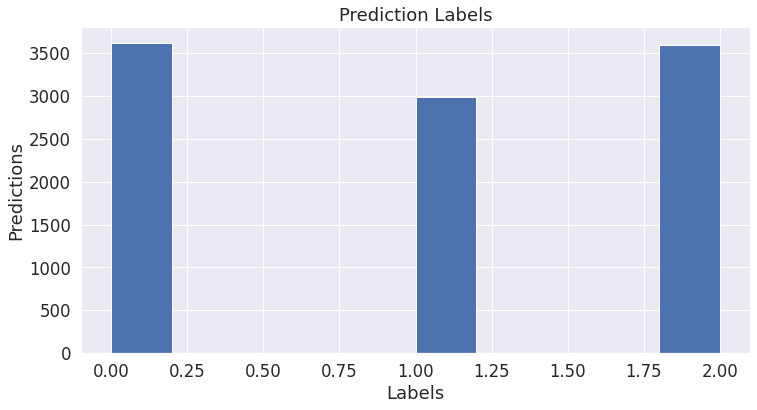

In [ ]:
# Distribution of Predictions
plt.hist(flat_list_multi)
plt.title('Prediction Labels')
plt.ylabel('Predictions')
plt.xlabel('Labels')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions_multi, axis=0)

# For each sample, pick the label (0 to 4) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels_multi = np.concatenate(true_labels_multi, axis=0)

# Calculate the MCC
acc = balanced_accuracy_score(flat_true_labels_multi, flat_predictions)

print('Total balanced_acc_set: %.3f' % acc)

Total balanced_acc_set: 0.752


Accuracy score:  0.7585834804787129


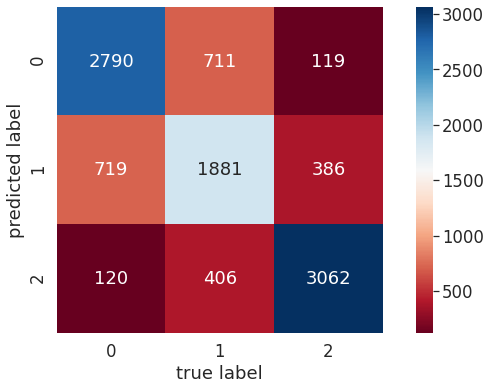

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(flat_predictions, flat_true_labels_multi)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=True, fmt='d')
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy score: ', accuracy_score(flat_predictions, flat_true_labels_multi))

In [ ]:
columns = ["1", "2", "3"]
rows = ["1", "2", "3"]
cm_multi_3 = pd.DataFrame(data=cm, index=rows, columns=columns)
print(cm_multi_3)
cm_multi_3.to_csv('confusion_matrix_multi_3.csv')
!cp confusion_matrix_multi_3.csv "drive/My Drive/Colab_Machine_Learning/Gespeicherte Modelle/Confusion_Matrices/"

      1     2     3
1  2790   711   119
2   719  1881   386
3   120   406  3062


## Saving Model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_multilingual_3/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model_mono.module if hasattr(model_mono, 'module') else model_mono  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_mono.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

!cp -r ./model_save_multilingual_3/ "drive/MyDrive/Colab_Machine_Learning/Gespeicherte Modelle/multilingual_3"

Saving model to ./model_save_multilingual_3/


# Backup

## Saving Model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_multilingual/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save_monolingual/


('./model_save_monolingual/tokenizer_config.json',
 './model_save_monolingual/special_tokens_map.json',
 './model_save_monolingual/vocab.txt',
 './model_save_monolingual/added_tokens.json')

In [ ]:
!ls

drive  model_save  model_save_monolingual  sample_data


In [ ]:
!cp -r ./model_save_monolingual/ "drive/MyDrive/Colab_Machine_Learning/Gespeicherte Modelle"

In [ ]:
import seaborn as sns
import matplotlib as plt
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [ ]:
train_df, test_df = train_test_split(df_Corona, test_size=0.10)
 
print('train shape: ',train_df.shape)
print('test shape: ',test_df.shape)

## Scraping Data

In [ ]:
result = reviews_all(
    'de.rki.coronawarnapp',
    sleep_milliseconds=0, # defaults to 0
    country='de', # defaults to 'us'
    lang='de', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
    filter_score_with=None # defaults to None(means all score)

)

In [ ]:
df_Corona.sort_values(by=['date'])

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,adjusted,date
47658,47658,gp:AOqpTOGMkuoJdrPmJKK20bihNNMC30_wKkZFTrjKCwY...,Johannes Büchs,https://play-lh.googleusercontent.com/a-/AOh14...,Gut gelungen!,5,0,1.0.0,2020-06-16 12:46:37,NaN,NaN,3,2020-06-16
49233,49233,gp:AOqpTOHwC_rELzkzbW9_5gFh0GHampVJrkYlHfBvZxR...,Amanda Seidel,https://play-lh.googleusercontent.com/-UToMBZd...,"Bewertungen,App-infos,Datenschutz durch gelese...",1,5,NaN,2020-06-16 09:36:19,Die App ist auch auf Englisch verfügbar. Kamer...,2020-06-17 19:43:04,1,2020-06-16
47806,47806,gp:AOqpTOGMDff8sZueVheRSd3ldMU0AHr8xpoRRdxFaIL...,Markus Teßmer,https://play-lh.googleusercontent.com/-kCUGHEI...,"Gesundheit geht vor, klasse Projekt! Auch wied...",5,0,1.0.0,2020-06-16 12:23:47,NaN,NaN,3,2020-06-16
49179,49179,gp:AOqpTOFmsYXTnSlAaW5h5z8liWKy3LTBu_X2GM7Wxae...,Hannes Keller,https://play-lh.googleusercontent.com/-aQWJqpD...,Must have!,5,0,1.0.0,2020-06-16 09:42:39,NaN,NaN,3,2020-06-16
48357,48357,gp:AOqpTOFAE2nGhQiHV7ucx3YEVDY8kAEJ5RDdk-mA-A2...,Elmar Grimm,https://play-lh.googleusercontent.com/-9q2HOBE...,Super gemacht danke an die Regierung ich helfe...,5,0,1.0.0,2020-06-16 11:29:45,NaN,NaN,3,2020-06-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,36,gp:AOqpTOEPdRHqcYNlwC8O1Qh_MTAQ17y4j7-5oIJ_YFF...,Sven Heinze,https://play-lh.googleusercontent.com/-CdGTKKz...,Für mich leider absolut unbrauchbar solange ic...,1,0,1.12.0,2021-03-05 07:17:04,Danke für Ihr Feedback. Ort und Uhrzeit werden...,2021-03-05 08:33:43,1,2021-03-05
46,46,gp:AOqpTOGxCGnqW09GMKvBJiYpgpHmG_2zxlwoveXbUyf...,Mika C.,https://play-lh.googleusercontent.com/-Sg8w3zN...,"Ich finde ein wichtiges feature fehlt, die Ris...",2,4,1.0.0,2021-03-05 02:16:04,Vielen Dank für Ihren Verbesserungsvorschlag. ...,2021-03-05 10:15:56,2,2021-03-05
4,4,gp:AOqpTOHaeFd-CgUQlF0fjLqIJKrV_fEnUFR_MIo2p_e...,Patryk Pastyranak,https://play-lh.googleusercontent.com/-GdziX_8...,Seit gestern wissen wir die Testergebnisse sch...,2,0,1.12.0,2021-03-05 13:35:44,Danke für Ihr Feedback. Um die Labore lückenlo...,2021-03-05 13:54:20,2,2021-03-05
43,43,gp:AOqpTOF41e-ZM45xbQNLvcDOqmUS7xNdAlB34YZ5VnH...,Flinkie,https://play-lh.googleusercontent.com/-BLgAb_G...,Totale Überwachung wird in DE eingeführt. Dazu...,1,83,NaN,2021-03-05 06:01:35,NaN,NaN,1,2021-03-05
